In [422]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time 
from sklearn.model_selection import train_test_split
import seaborn as sb

input_file="DIS.csv"

In [423]:
df=pd.read_csv(input_file)
np.random.seed(5)
df.head()

,1996-12-31,23.011177,23.175543,22.805719,22.928993,17.804647,2719200
0,1997-01-02,22.928993,22.970085,21.942801,22.148258,17.198397,8115400
1,1997-01-03,22.394806,22.805719,22.394806,22.764629,17.677013,4650000
2,1997-01-06,22.764629,22.928993,22.559172,22.682446,17.613201,3623300
3,1997-01-07,22.682446,22.682446,22.435898,22.641354,17.581289,3606200
4,1997-01-08,22.641354,22.805719,22.189348,22.312624,17.353743,3225400


### Closing prices of stock

In [424]:
close_price=df.iloc[:,5].values
close_price=close_price.reshape(-1,1)
close_price

array([[ 17.198397],
       [ 17.677013],
       [ 17.613201],
       ...,
       [102.703629],
       [102.959648],
       [102.624855]])

### Scaling values between 0 & 1. Machine Learning algorithms work better when features are on relatively similar scale & closer to normal distribution

In [425]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = scaler.fit_transform(close_price)

In [426]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Reshape into X=t and Y=t+1, timestep 240

In [427]:
train_size = int(len(close_price) * 0.6)
test_size = len(close_price) - train_size
train, test = close_price[0:train_size,:], close_price[train_size:len(close_price),:]
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [428]:
trainX

array([[0.05843065, 0.0629325 , 0.06233229, ..., 0.12460893, 0.12340048,
        0.12098349],
       [0.0629325 , 0.06233229, 0.06203212, ..., 0.12340048, 0.12098349,
        0.12294722],
       [0.06233229, 0.06203212, 0.05989183, ..., 0.12098349, 0.12294722,
        0.13140648],
       ...,
       [0.14159657, 0.14143246, 0.13273464, ..., 0.07930634, 0.0786401 ,
        0.07980605],
       [0.14143246, 0.13273464, 0.13060119, ..., 0.0786401 , 0.07980605,
        0.08138848],
       [0.13273464, 0.13060119, 0.12740104, ..., 0.07980605, 0.08138848,
        0.07547521]])

In [429]:
trainY

array([0.12294722, 0.13140648, 0.12868748, ..., 0.08138848, 0.07547521,
       0.08388698])

In [430]:
list(zip(trainX,trainY))

[(array([0.05843065, 0.0629325 , 0.06233229, 0.06203212, 0.05989183,
         0.05899001, 0.05989183, 0.06019242, 0.06319851, 0.06289792,
         0.06229668, 0.06500214, 0.06620452, 0.06440092, 0.06680576,
         0.06590392, 0.06800816, 0.06890996, 0.07131487, 0.07402037,
         0.07071365, 0.071916  , 0.071916  , 0.07131487, 0.07161547,
         0.07462148, 0.07702638, 0.07852937, 0.07702638, 0.0809343 ,
         0.08273787, 0.08454153, 0.0830385 , 0.0797318 , 0.07642514,
         0.07792822, 0.07852937, 0.0797318 , 0.07822884, 0.07913061,
         0.07522276, 0.07311848, 0.07161547, 0.07341907, 0.07732694,
         0.07943128, 0.08123485, 0.08213667, 0.07792822, 0.07281791,
         0.07642514, 0.07943128, 0.07822884, 0.07702638, 0.07582394,
         0.07462148, 0.07702638, 0.07642514, 0.07762756, 0.07702638,
         0.071916  , 0.07071365, 0.07071365, 0.07131487, 0.07402037,
         0.07402037, 0.07432094, 0.07433774, 0.07493999, 0.07102518,
         0.06801372, 0.07463888, 0

### Reshape input to be [samples, time steps, features]

In [431]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Building LSTM model

In [432]:
model = keras.Sequential([
keras.layers.LSTM(25, input_shape=(1, look_back)),
keras.layers.Dropout(0.1),
keras.layers.Dense(1)
])

In [433]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 25)                26600     
_________________________________________________________________
dropout_21 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 26        
Total params: 26,626
Trainable params: 26,626
Non-trainable params: 0
_________________________________________________________________


### Setting optimizer, loss_fn & accuracy

In [434]:
model.compile(loss='mse', optimizer='adam',metrics=['mse'])

In [435]:
ACCURACY_THRESH=0.90

class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('acc')>=ACCURACY_THRESH:
            print('Desired accuracy reached.....stopping training')
            self.model.stop_training=True

callbacks=myCallback()

In [437]:
model.fit(trainX, trainY, epochs=300,batch_size=240, verbose=1)

Epoch 1/300
12/12 [==============================] - 0s 3ms/step - loss: 7.1314e-04 - mse: 7.1314e-04
Epoch 2/300
12/12 [==============================] - 0s 4ms/step - loss: 4.6840e-04 - mse: 4.6840e-04
Epoch 3/300
12/12 [==============================] - 0s 3ms/step - loss: 4.0541e-04 - mse: 4.0541e-04
Epoch 4/300
12/12 [==============================] - 0s 3ms/step - loss: 3.2779e-04 - mse: 3.2779e-04
Epoch 5/300
12/12 [==============================] - 0s 3ms/step - loss: 2.7768e-04 - mse: 2.7768e-04
Epoch 6/300
12/12 [==============================] - 0s 3ms/step - loss: 2.5134e-04 - mse: 2.5134e-04
Epoch 7/300
12/12 [==============================] - 0s 4ms/step - loss: 2.3942e-04 - mse: 2.3942e-04
Epoch 8/300
12/12 [==============================] - 0s 3ms/step - loss: 2.2088e-04 - mse: 2.2088e-04
Epoch 9/300
12/12 [==============================] - 0s 4ms/step - loss: 2.0898e-04 - mse: 2.0898e-04
Epoch 10/300
12/12 [==============================] - 0s 3ms/step - loss: 1.9279e-

12/12 [==============================] - 0s 4ms/step - loss: 7.7214e-05 - mse: 7.7214e-05
Epoch 81/300
12/12 [==============================] - 0s 4ms/step - loss: 7.8262e-05 - mse: 7.8262e-05
Epoch 82/300
12/12 [==============================] - 0s 3ms/step - loss: 7.2258e-05 - mse: 7.2258e-05
Epoch 83/300
12/12 [==============================] - 0s 3ms/step - loss: 7.9630e-05 - mse: 7.9630e-05
Epoch 84/300
12/12 [==============================] - 0s 3ms/step - loss: 8.1204e-05 - mse: 8.1204e-05
Epoch 85/300
12/12 [==============================] - 0s 3ms/step - loss: 8.8258e-05 - mse: 8.8258e-05
Epoch 86/300
12/12 [==============================] - 0s 3ms/step - loss: 7.7318e-05 - mse: 7.7318e-05
Epoch 87/300
12/12 [==============================] - 0s 3ms/step - loss: 7.5941e-05 - mse: 7.5941e-05
Epoch 88/300
12/12 [==============================] - 0s 3ms/step - loss: 6.9866e-05 - mse: 6.9866e-05
Epoch 89/300
12/12 [==============================] - 0s 3ms/step - loss: 7.4329e-05 -

12/12 [==============================] - 0s 3ms/step - loss: 5.8508e-05 - mse: 5.8508e-05
Epoch 160/300
12/12 [==============================] - 0s 3ms/step - loss: 6.0074e-05 - mse: 6.0074e-05
Epoch 161/300
12/12 [==============================] - 0s 3ms/step - loss: 5.9174e-05 - mse: 5.9174e-05
Epoch 162/300
12/12 [==============================] - 0s 6ms/step - loss: 6.1466e-05 - mse: 6.1466e-05
Epoch 163/300
12/12 [==============================] - 0s 5ms/step - loss: 5.1702e-05 - mse: 5.1702e-05
Epoch 164/300
12/12 [==============================] - 0s 5ms/step - loss: 5.2402e-05 - mse: 5.2402e-05
Epoch 165/300
12/12 [==============================] - 0s 6ms/step - loss: 5.5359e-05 - mse: 5.5359e-05
Epoch 166/300
12/12 [==============================] - 0s 3ms/step - loss: 5.0242e-05 - mse: 5.0242e-05
Epoch 167/300
12/12 [==============================] - 0s 3ms/step - loss: 5.1355e-05 - mse: 5.1355e-05
Epoch 168/300
12/12 [==============================] - 0s 3ms/step - loss: 5.0

12/12 [==============================] - 0s 3ms/step - loss: 4.6088e-05 - mse: 4.6088e-05
Epoch 238/300
12/12 [==============================] - 0s 3ms/step - loss: 5.5174e-05 - mse: 5.5174e-05
Epoch 239/300
12/12 [==============================] - 0s 3ms/step - loss: 4.4878e-05 - mse: 4.4878e-05
Epoch 240/300
12/12 [==============================] - 0s 3ms/step - loss: 4.5534e-05 - mse: 4.5534e-05
Epoch 241/300
12/12 [==============================] - 0s 3ms/step - loss: 4.7242e-05 - mse: 4.7242e-05
Epoch 242/300
12/12 [==============================] - 0s 3ms/step - loss: 4.6208e-05 - mse: 4.6208e-05
Epoch 243/300
12/12 [==============================] - 0s 3ms/step - loss: 4.5863e-05 - mse: 4.5863e-05
Epoch 244/300
12/12 [==============================] - 0s 3ms/step - loss: 4.5350e-05 - mse: 4.5350e-05
Epoch 245/300
12/12 [==============================] - 0s 3ms/step - loss: 4.1880e-05 - mse: 4.1880e-05
Epoch 246/300
12/12 [==============================] - 0s 3ms/step - loss: 4.5

### Saving the trained model

In [443]:
from keras.models import load_model
model.save('trained_model.h5')  # creates a HDF5 file 'my_model.h5'

#Load back the trained model
#model = load_model('my_model.h5')

### Predictions & Visualization

In [439]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [440]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [441]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.56 RMSE
Test Score: 7.74 RMSE


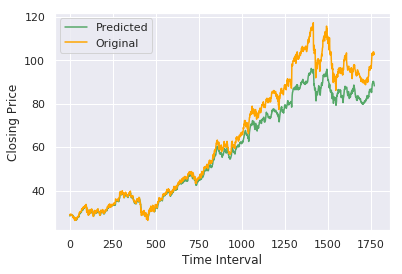

In [442]:
plt.plot(testPredict,color='g')
plt.plot(testY.reshape(-1,1),color='orange')
plt.ylabel('Closing Price')
plt.xlabel('Time Interval')
plt.legend(["Predicted", "Original"], loc ="upper left") 
plt.show()
sb.set()